## Implement RandomSearchCV with k fold cross validation on KNN

In [57]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2,n_classes=3, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

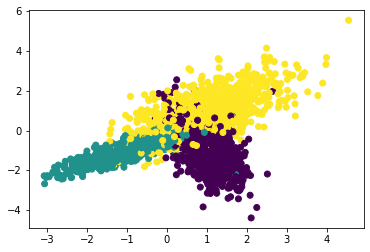

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
#colors = {0:'orange', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom GridSearchCV

In [59]:
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    trainscores = []
    testscores  = []    
    global params
    params=[]
    seed(7)
    params= random.sample(range(param_range[0],param_range[1]), 10) # creating random set of unique numbers
    params.sort() # sorting parameters
    print(params)
    length = int(len(x_train)/folds) 
    foldsX = []
    foldsY = []
    for i in range(folds-1):
        foldsX += [x_train[i*length:(i+1)*length]]
        foldsY += [y_train[i*length:(i+1)*length]]        #block of statement used for creating folds
    foldsX += [x_train[(folds-1)*length:len(x_train)]]
    foldsY += [y_train[(folds-1)*length:len(y_train)]]
    for k in tqdm(params):
        trainscores_folds = []
        testscores_folds  = []
        for j in range(0, folds):
            X_test  = foldsX[j]
            Y_test  = foldsY[j]
            G=np.delete(foldsX,j,0)      #removing cross validation data 
            V=np.delete(foldsY,j,0)
            X_train = np.concatenate(G)
            Y_train =  np.concatenate(V) # data used for training
            
            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train) 
            
            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted)) # calculating accuracy score for each fold
            
            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds))) # calculating the accuracy score for each k
    return trainscores,testscores

100%|██████████| 11/11 [00:04<00:00,  2.51it/s]


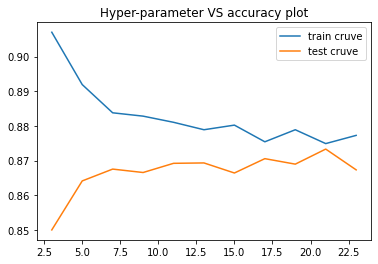

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

params = {'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23]}
folds = 3

trainscores,testscores = GridSearch(X_train, y_train, neigh, params, folds)
 

plt.plot(params['n_neighbors'],trainscores, label='train cruve')
plt.plot(params['n_neighbors'],testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [61]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

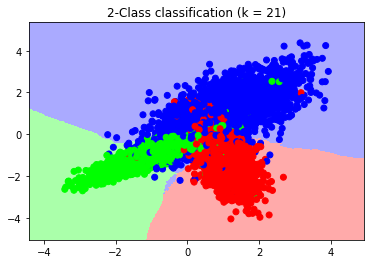

In [62]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 21)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

In [63]:
from sklearn.metrics import accuracy_score


def randomized_search_cv_custom(x_train_total, y_train_total, classifier, param_range, num_of_total_fold):
    # x_train_total: its numpy array of shape, (n,d)
    # y_train_total: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: Integer representing how many hyper-parameters I am considering for each iteration
    # num_of_total_fold: an integer, represents number of num_of_total_fold we need to devide the data and test our model

    # generating hyper-parameter range
    # generate 10 unique values(uniform random distribution) in the given range - starting 1 to "param_range"
    # ex: if param_range = 50, we need to generate 10 random numbers in range 1 to 50
    ten_random_values_for_param_range = sorted(random.sample(range(1, param_range), 10))

    train_scores = []
    test_scores = []

    classifier_params = { 'n_neighbors': ten_random_values_for_param_range }
    # it will take classifier and set of values for hyper parameters in dict type
    # dict({hyper parmeter: [list of values]})
    # as we are implementing this only for KNN, the hyper parameter should be n_neighbors
    # And I will return it from the function at the end so that I can use this same hyper-param
    # while plotting the graph as well

    for k in tqdm(classifier_params['n_neighbors']):
        trainscores_folds = []
        testscores_folds = []

        for fold in range(0, num_of_total_fold):
            # divide numbers ranging from  0 to len(x_train_fold) into groups = num_of_total_fold
            # basically, splitting the data into k groups (k = len(x_train_fold) / num_of_total_fold)
            # It works by first training the algorithm on the k_1 group of the data and
            # evaluating it on the kth hold-out group as the test set. This is repeated
            # so that each of the k groups is given an opportunity to be held out and used as the test set.
            # ex: num_of_total_fold=3, and len(x_train_total)=100, we can divide numbers from 0 to 100 into 3 groups
            # group 1: 0-33, group 2:34-66, group 3: 67-100
            num_of_elements_in_each_fold = int(len(x_train_total) / num_of_total_fold)

            # for each hyperparameter that we generated in step 1:
            # and using the above groups we have created in step 2 you will do cross-validation as follows

            # first we will keep group 1+group 2 i.e. 0-66 as train data and
            # group 3: 67-100 as test data, and find train and test accuracies
            # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and
            # group 2: 34-66 as test data, and find train and test accuracies
            # third we will keep group 2+group 3 i.e. 34-100 as train data and
            # group 1: 0-33 as test data, and find train and test accuracies
            # based on the 'num_of_total_fold' value we will do the same procedure

            # NOW IMPLEMENTATION OF THE CONCEPT OF 'fold' as below
            # For each of this inner loop running for values of fold (where fold represents num_of_total_fold of 0, 1, 2, 3 ...)
            # each of the test_indices will have the data of a single fold ( which is = num_of_elements_in_each_fold )
            # i.e. the test_indices will be the range starting at
            # num_of_elements_in_each_fold * fold and ending at num_of_elements_in_each_fold * (fold + 1)
            # And this whole range needs to be converted to list => then apply set() to the list
            # => and then again converted to list
            test_indices = list(set(list(range((num_of_elements_in_each_fold * fold), (num_of_elements_in_each_fold*(fold+1))))))
            # print('test_indices ', test_indices)

            # And the rest of the indices of the dataset will be the train_indices
            train_indices = list(set(list(range(0, len(x_train_total)))) - set(test_indices) )
            # print('train_indices ', train_indices)

            ''' So for a dataset of total 100 rows, one loop of fold, will have the following test_indices and train_indices

            test_indices  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

            train_indices  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]

            And the next loop of j will have as below (for the same dataset of total 100 rows )

            test_indices  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
            
            train_indices  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
            '''

            # after we have above, now select datapoints based on test_indices and train_indices
            x_train_fold = x_train_total[train_indices]
            y_train_fold = y_train_total[train_indices]
            x_test_fold = x_train_total[test_indices]
            y_test_fold = y_train_total[test_indices]

            # Now based on our classifier assign corresponding parameter values
            # and also fit() and predict()
            classifier.n_neighbors = k
            classifier.fit(x_train_fold, y_train_fold)

            # First predict based on x_test_fold and keep the accuracy score in the testscores_folds
            y_predicted = classifier.predict(x_test_fold)
            testscores_folds.append(accuracy_score(y_test_fold, y_predicted))

            # Now run prediction based on x_train_fold and append the accuracy score in the trainscores_folds
            y_predicted = classifier.predict(x_train_fold)
            trainscores_folds.append(accuracy_score(y_train_fold, y_predicted))

        train_scores.append(np.mean(np.array(trainscores_folds)))
        test_scores.append(np.mean(np.array(testscores_folds)))

    return train_scores, test_scores, classifier_params


In [64]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Our Classifier is KNN, hence assign a variable to it.
neigh = KNeighborsClassifier()
params_range = 50
number_of_total_folds = 3

# Now invoking our custom function randomized_search_cv_custom(x_train,y_train,classifier, param_range, num_of_total_fold) and store the returned values
testscores, trainscores, params = randomized_search_cv_custom(X_train, y_train, neigh, params_range, number_of_total_folds)

print('trainscores are: ', trainscores)
print('testscores are: ', testscores)

100%|██████████| 10/10 [00:04<00:00,  2.45it/s]

trainscores are:  [0.8301333333333334, 0.8540000000000001, 0.8668, 0.8677333333333332, 0.868, 0.8692000000000001, 0.87, 0.8697333333333334, 0.8706666666666667, 0.8725333333333333]
testscores are:  [0.9077333333333333, 0.8956, 0.884, 0.8802666666666666, 0.8757999999999999, 0.8773333333333332, 0.8770666666666666, 0.8762666666666666, 0.8760666666666667, 0.8748666666666667]


# Plotting hyper-parameter vs accuracy plot

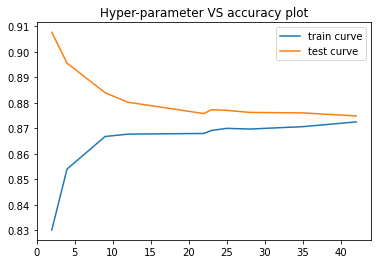

In [65]:
# Now plotting hyper-parameter vs accuracy plot to choose the best hyperparameter
plt.plot(params['n_neighbors'], trainscores, label='train curve')
plt.plot(params['n_neighbors'], testscores, label='test curve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

#### Observation:

##### 1-from the above curve we an conclude k value near to 30 will give good accuracy.
##### 2-Because of taking random value of k, this graph is changing for each iteration

In [66]:
def plot_decision_boundary(X1, X2, y, clf):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

# Plotting the decision boundaries for the model initialized with the best hyperparameter

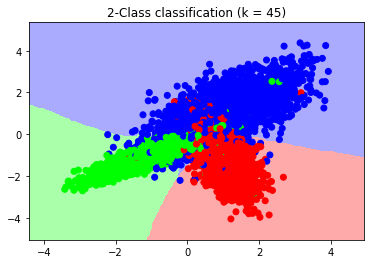

In [67]:
# plotting the decision boundaries for the model initialized with the best hyperparameter (45)
neigh = KNeighborsClassifier(n_neighbors = 45)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)